In [1]:
# 1. ====================== CONFIGURAÇÕES INICIAIS ======================
# Bibliotecas necessárias
import numpy as np
import pandas as pd
import os
import gdown
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Saídas
pasta_download = "download"
os.makedirs(pasta_download, exist_ok=True)
sns.set_style("whitegrid")

In [2]:
# 2. ====================== CARREGAMENTO DE DADOS ======================
# IDs dos arquivos
brasil = ["1jrBtlb1gMlHk8fH8m2l7B8TXuJU4NUn6",
          "1EPNjLOUIZ_EysDRyNN2DY4fUgQgV4lxg",
          "1vklnFIR4j99w_YXLjIAdurh6WRYm-OKI"]

# Dicionário para armazenar os DataFrames
dataframes_brasil = {}

# Baixar e carregar arquivos
for i, file_id in enumerate(brasil):
    url = f"https://drive.google.com/uc?id={file_id}"
    output = f"arquivo_brasil_{i+1}.parquet"
    gdown.download(url, output, quiet=False)
    dataframes_brasil[f"brasil_{i+1}"] = pd.read_parquet(output)
    print(f"Arquivo {i+1} baixado e carregado.")

# Combinar os DataFrames
df_male = dataframes_brasil['brasil_1']
df_female = dataframes_brasil['brasil_2']
df_both = dataframes_brasil['brasil_3']

df_male['Sexo'] = 'Masculino'
df_female['Sexo'] = 'Feminino'
df_both['Sexo'] = 'Ambos'

df = pd.concat([df_male, df_female, df_both], ignore_index=True)

# Mostrar informações sobre os dados
print("\nInformações do DataFrame combinado:")
print(f"Total de registros: {len(df)}")
print(f"Locais únicos: {df['Local'].nunique()}")
print(f"Anos disponíveis: {df['Ano'].min()} a {df['Ano'].max()}")
print(f"Grupos etários: {df['Grupo Etário'].nunique()}")

Downloading...
From: https://drive.google.com/uc?id=1jrBtlb1gMlHk8fH8m2l7B8TXuJU4NUn6
To: /content/arquivo_brasil_1.parquet
100%|██████████| 1.18M/1.18M [00:00<00:00, 124MB/s]


Arquivo 1 baixado e carregado.


Downloading...
From: https://drive.google.com/uc?id=1EPNjLOUIZ_EysDRyNN2DY4fUgQgV4lxg
To: /content/arquivo_brasil_2.parquet
100%|██████████| 1.16M/1.16M [00:00<00:00, 129MB/s]


Arquivo 2 baixado e carregado.


Downloading...
From: https://drive.google.com/uc?id=1vklnFIR4j99w_YXLjIAdurh6WRYm-OKI
To: /content/arquivo_brasil_3.parquet
100%|██████████| 1.17M/1.17M [00:00<00:00, 134MB/s]

Arquivo 3 baixado e carregado.

Informações do DataFrame combinado:
Total de registros: 47520
Locais únicos: 33
Anos disponíveis: 2000 a 2023
Grupos etários: 20


In [4]:
# 3. ====================== FUNÇÕES AUXILIARES ======================
def parse_grupo_etario(grupo_str):
    """Converte string de grupo etário em (idade_inicial, n)"""
    if '+' in grupo_str:
        idade = int(grupo_str.replace('+', ''))
        return idade, 1
    elif '-' in grupo_str:
        inicio, fim = map(int, grupo_str.split('-'))
        return inicio, fim - inicio + 1
    else:
        return int(grupo_str), 1

# Processar grupos etários
df[['idade_inicial', 'n']] = df['Grupo Etário'].apply(
    lambda x: pd.Series(parse_grupo_etario(x))
)
df = df.sort_values(['Local', 'Sexo', 'Ano', 'idade_inicial'])

def calcular_tabua_vida_grupos(mx, ax, n_grupos):
    """Calcula a expectativa de vida para grupos etários."""
    num_grupos = len(mx)
    qx = np.zeros(num_grupos)
    lx = np.zeros(num_grupos)
    dx = np.zeros(num_grupos)
    Lx = np.zeros(num_grupos)
    Tx = np.zeros(num_grupos)

    lx[0] = 100000

    for i in range(num_grupos):
        n = n_grupos[i]
        if i == num_grupos - 1:  # Grupo aberto
            qx[i] = 1.0
        else:
            qx[i] = (n * mx[i]) / (1 + (n - ax[i]) * mx[i])

        dx[i] = lx[i] * qx[i]
        Lx[i] = n * (lx[i] - dx[i]) + ax[i] * dx[i] if i < num_grupos - 1 else lx[i] / mx[i]

        if i < num_grupos - 1:
            lx[i+1] = lx[i] - dx[i]

    Tx[-1] = Lx[-1]
    for i in range(num_grupos-2, -1, -1):
        Tx[i] = Tx[i+1] + Lx[i]

    return Tx[0] / lx[0]  # ex (expectativa de vida ao nascer)

# Definir ordem correta dos grupos etários
ORDEM_GRUPOS = ['0', '1-4', '5-9', '10-14', '15-19', '20-24', '25-29',
                '30-34', '35-39', '40-44', '45-49', '50-54', '55-59',
                '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90+']

def sMAPE(actual, predicted):
    """Calcula o sMAPE simétrico corrigido"""
    actual, predicted = np.array(actual), np.array(predicted)
    denominator = (np.abs(actual) + np.abs(predicted))
    return 200 * np.mean(np.where(denominator != 0,
                                 np.abs(predicted - actual) / denominator,
                                 0))

def ajustar_arima(serie, max_ordem=3):
    """Seleciona melhor ARIMA via AIC e retorna (modelo, ordem)"""
    melhor_aic = np.inf
    melhor_modelo = None
    melhor_ordem = (0, 0, 0)
    for p in range(max_ordem + 1):
        for d in range(3):  # d pode ser 0, 1, 2
            for q in range(max_ordem + 1):
                try:
                    modelo = ARIMA(serie, order=(p, d, q)).fit()
                    if modelo.aic < melhor_aic:
                        melhor_aic = modelo.aic
                        melhor_modelo = modelo
                        melhor_ordem = (p, d, q)
                except:
                    continue
    print(f"Melhor modelo: ARIMA{melhor_ordem} - AIC: {melhor_aic:.2f}")
    return melhor_modelo, melhor_ordem

In [5]:
# Filtrar Local Brasil
df = df[df['Local'] == 'Brasil']
df

,Ano,Grupo Etário,nMx,nqx,nAx,lx,ndx,nLx,Tx,ex,Local,Sexo,idade_inicial,n
31680,2000,0,0.028834,0.028127,0.128739,100000.000000,2812.697459,97549.406182,7.110219e+06,71.102185,Brasil,Ambos,0,1
31681,2000,1-4,0.001150,0.004588,1.524332,97187.302541,445.882150,387645.354108,7.012669e+06,72.156227,Brasil,Ambos,1,4
31682,2000,5-9,0.000376,0.001881,2.286499,96741.420390,181.924588,483213.449343,6.625024e+06,68.481771,Brasil,Ambos,5,5
31683,2000,10-14,0.000436,0.002178,2.751711,96559.495802,210.311936,482324.637048,6.141810e+06,63.606487,Brasil,Ambos,10,5
31684,2000,15-19,0.001266,0.006311,2.800300,96349.183866,608.103078,480408.275043,5.659486e+06,58.739321,Brasil,Ambos,15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,2023,70-74,0.032080,0.148910,2.594650,67016.843265,9979.470758,311080.098441,9.307820e+05,13.888777,Brasil,Masculino,70,5
476,2023,75-79,0.049852,0.222467,2.584288,57037.372507,12688.950551,254534.016870,6.197019e+05,10.864839,Brasil,Masculino,75,5
477,2023,80-84,0.079149,0.331174,2.536528,44348.421957,14687.024693,185561.030597,3.651678e+05,8.234066,Brasil,Masculino,80,5
478,2023,85-89,0.131089,0.490762,2.440164,29661.397263,14556.698801,111044.221352,1.796068e+05,6.055238,Brasil,Masculino,85,5


In [16]:
# 3. ====================== FUNÇÕES AUXILIARES ======================
def parse_grupo_etario(grupo_str):
    """Converte string de grupo etário em (idade_inicial, n)"""
    if '+' in grupo_str:
        idade = int(grupo_str.replace('+', ''))
        return idade, 1
    elif '-' in grupo_str:
        inicio, fim = map(int, grupo_str.split('-'))
        return inicio, fim - inicio + 1
    else:
        return int(grupo_str), 1

# Processar grupos etários
df[['idade_inicial', 'n']] = df['Grupo Etário'].apply(
    lambda x: pd.Series(parse_grupo_etario(x))
)
df = df.sort_values(['Local', 'Sexo', 'Ano', 'idade_inicial'])

def calcular_tabua_vida_grupos(mx, ax, n_grupos):
    """Calcula a expectativa de vida para grupos etários."""
    num_grupos = len(mx)
    qx = np.zeros(num_grupos)
    lx = np.zeros(num_grupos)
    dx = np.zeros(num_grupos)
    Lx = np.zeros(num_grupos)
    Tx = np.zeros(num_grupos)

    lx[0] = 100000

    for i in range(num_grupos):
        n = n_grupos[i]
        if i == num_grupos - 1:  # Grupo aberto
            qx[i] = 1.0
        else:
            qx[i] = (n * mx[i]) / (1 + (n - ax[i]) * mx[i])

        dx[i] = lx[i] * qx[i]
        Lx[i] = n * (lx[i] - dx[i]) + ax[i] * dx[i] if i < num_grupos - 1 else lx[i] / mx[i]

        if i < num_grupos - 1:
            lx[i+1] = lx[i] - dx[i]

    Tx[-1] = Lx[-1]
    for i in range(num_grupos-2, -1, -1):
        Tx[i] = Tx[i+1] + Lx[i]

    return Tx[0] / lx[0]  # ex (expectativa de vida ao nascer)

# Definir ordem correta dos grupos etários
ORDEM_GRUPOS = ['0', '1-4', '5-9', '10-14', '15-19', '20-24', '25-29',
                '30-34', '35-39', '40-44', '45-49', '50-54', '55-59',
                '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90+']

def sMAPE(actual, predicted):
    """Calcula o sMAPE simétrico corrigido"""
    actual, predicted = np.array(actual), np.array(predicted)
    denominator = (np.abs(actual) + np.abs(predicted))
    return 200 * np.mean(np.where(denominator != 0,
                                 np.abs(predicted - actual) / denominator,
                                 0))

def ajustar_arima(serie, max_ordem=3):
    """Seleciona melhor ARIMA via AIC conforme Lee-Carter (1992)"""
    melhor_aic = np.inf
    melhor_modelo = None
    melhor_ordem = (0, 0, 0)
    for p in range(max_ordem + 1):
        for d in range(2):  # d normalmente 0 ou 1
            for q in range(max_ordem + 1):
                try:
                    modelo = ARIMA(serie, order=(p, d, q)).fit()
                    if modelo.aic < melhor_aic:
                        melhor_aic = modelo.aic
                        melhor_modelo = modelo
                        melhor_ordem = (p, d, q)
                except:
                    continue
    print(f"Melhor modelo: ARIMA{melhor_ordem} - AIC: {melhor_aic:.2f}")
    return melhor_modelo, melhor_ordem

In [17]:
# 4. ====================== MODELAGEM POR GRUPO ======================
for (local, sexo), grupo in df.groupby(['Local', 'Sexo']):
    print(f"\nProcessando: {local} - {sexo}")

    # 4.1. Preparar dados com ordenação correta
    grupo['Grupo Etário'] = pd.Categorical(
        grupo['Grupo Etário'],
        categories=ORDEM_GRUPOS,
        ordered=True
    )
    grupo = grupo.sort_values(['Grupo Etário', 'idade_inicial'])

    dados = grupo.pivot_table(
        index='Grupo Etário',
        columns='Ano',
        values='nMx'
    ).loc[ORDEM_GRUPOS]  # Garantir ordem correta

    # Dividir em treino (2000-2014) e teste (2015-2019)
    dados_treino = dados.loc[:, 2000:2014]
    dados_teste = dados.loc[:, 2015:2019]

    # 4.2. Modelagem Lee-Carter (só com treino)
    log_mx_treino = np.log(dados_treino)
    ax = log_mx_treino.mean(axis=1)
    Z = log_mx_treino.sub(ax, axis=0)
    U, S, Vt = np.linalg.svd(Z, full_matrices=False)

    # Normalização conforme Lee-Carter (1992)
    bx = U[:, 0] / U[:, 0].sum()
    kt_treino = Vt[0, :] * S[0] * U[:, 0].sum()
    kt_serie = pd.Series(kt_treino - kt_treino.mean(), index=dados_treino.columns)

    # 4.3. MODELAGEM DE κ_t COM ARIMA (Conforme Lee-Carter 1992)
    modelo_arima, ordem_arima = ajustar_arima(kt_serie)

    # 4.4. Previsões para teste (2015-2019) e futuro (2020-2070)
    anos_teste = dados_teste.columns.tolist()
    anos_futuro = list(range(2020, 2071))
    total_previsao = len(anos_teste) + len(anos_futuro)

    previsao = modelo_arima.get_forecast(steps=total_previsao)
    previsao_kt = previsao.predicted_mean
    conf_int = previsao.conf_int()
    previsao_kt.index = anos_teste + anos_futuro
    conf_int.index = anos_teste + anos_futuro

    # 4.5. Calcular projeções de mx mantendo ordem
    projecoes = pd.DataFrame(index=dados.index)

    # Preencher com dados reais de treino
    for ano in dados_treino.columns:
        projecoes[ano] = dados_treino[ano]

    # Preencher com projeções (teste + futuro)
    for ano in previsao_kt.index:
        kt_val = previsao_kt[ano]
        log_mx_proj = ax + bx * kt_val
        projecoes[ano] = np.exp(log_mx_proj)

    # 4.6. Preparar parâmetros para cálculo da tábua de vida
    grupos_info = grupo[['Grupo Etário', 'n']].drop_duplicates().set_index('Grupo Etário')
    n_grupos = grupos_info.loc[projecoes.index, 'n'].values
    ax_medio = grupo.groupby('Grupo Etário')['nAx'].mean()
    ax_vals = ax_medio.loc[projecoes.index].values

    # 4.7. Calcular expectativa de vida
    ex_proj = {}
    for ano in projecoes.columns:
        mx_ano = projecoes[ano].values
        ex_proj[ano] = calcular_tabua_vida_grupos(mx_ano, ax_vals, n_grupos)

    # 5. CÁLCULO DE MÉTRICAS (PERÍODO DE TESTE: 2015-2019) =============
    metricas = []
    for idade in dados.index:
        mask_obs = (grupo['Grupo Etário'] == idade) & (grupo['Ano'].between(2015, 2019))
        mx_observado = grupo.loc[mask_obs].set_index('Ano')['nMx']
        mx_projetado = projecoes.loc[idade, anos_teste]

        if len(mx_observado) > 0:
            y_true = mx_observado.sort_index()
            y_pred = mx_projetado.loc[y_true.index]

            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            smape_val = sMAPE(y_true, y_pred)
            mae = mean_absolute_error(y_true, y_pred)

            metricas.append({
                'Local': local,
                'Sexo': sexo,
                'Grupo Etário': idade,
                'RMSE': rmse,
                'sMAPE': smape_val,
                'MAE': mae
            })

    # 6. SALVAR RESULTADOS =============================================
    resultados = []
    for ano in projecoes.columns:
        for i, idade in enumerate(projecoes.index):
            mx_val = projecoes.loc[idade, ano]
            linha = {
                'Local': local,
                'Sexo': sexo,
                'Ano': ano,
                'Grupo Etário': idade,
                'Previsão': mx_val,
                'Expectativa_Vida': ex_proj[ano] if idade == '0' else None
            }

            if ano >= 2015:
                kt_inf = conf_int.loc[ano, 'lower y']
                kt_sup = conf_int.loc[ano, 'upper y']
                log_mx_inf = ax.loc[idade] + bx[i] * kt_inf
                log_mx_sup = ax.loc[idade] + bx[i] * kt_sup
                linha['Limite Inferior'] = np.exp(log_mx_inf)
                linha['Limite Superior'] = np.exp(log_mx_sup)
            else:
                linha['Limite Inferior'] = mx_val
                linha['Limite Superior'] = mx_val

            resultados.append(linha)

    # Filtrar apenas anos >= 2020
    df_resultados = pd.DataFrame([r for r in resultados if r['Ano'] >= 2020])
    df_resultados['Grupo Etário'] = pd.Categorical(
        df_resultados['Grupo Etário'],
        categories=ORDEM_GRUPOS,
        ordered=True
    )
    df_resultados = df_resultados.sort_values(['Ano', 'Grupo Etário'])

    df_metricas = pd.DataFrame(metricas)
    df_metricas['Grupo Etário'] = pd.Categorical(
        df_metricas['Grupo Etário'],
        categories=ORDEM_GRUPOS,
        ordered=True
    )
    df_metricas = df_metricas.sort_values('Grupo Etário')

    # 6.3. Escrever arquivos
    nome_base = f"{local}_{sexo}".replace(" ", "_").replace("/", "-")
    df_resultados.to_csv(os.path.join(pasta_download, f"proj_{nome_base}.csv"), index=False)
    df_metricas.to_csv(os.path.join(pasta_download, f"metricas_{nome_base}.csv"), index=False)

print("Processamento concluído!")


Processando: Brasil - Ambos
Melhor modelo: ARIMA(1, 1, 0) - AIC: -17.95

Processando: Brasil - Feminino
Melhor modelo: ARIMA(1, 1, 0) - AIC: -20.14

Processando: Brasil - Masculino
Melhor modelo: ARIMA(2, 1, 0) - AIC: -15.90
Processamento concluído!


In [18]:
# Carregar dados de homens
df_male = pd.read_csv(os.path.join(pasta_download, "proj_Brasil_Masculino.csv"))
df_male

,Local,Sexo,Ano,Grupo Etário,Previsão,Expectativa_Vida,Limite Inferior,Limite Superior
0,Brasil,Masculino,2020,0,0.010675,72.804296,0.008740,0.013039
1,Brasil,Masculino,2020,1-4,0.000427,NaN,0.000354,0.000516
2,Brasil,Masculino,2020,5-9,0.000243,NaN,0.000218,0.000272
3,Brasil,Masculino,2020,10-14,0.000376,NaN,0.000355,0.000399
4,Brasil,Masculino,2020,15-19,0.002046,NaN,0.002072,0.002021
...,...,...,...,...,...,...,...,...
1015,Brasil,Masculino,2070,70-74,0.021364,NaN,0.008177,0.055816
1016,Brasil,Masculino,2070,75-79,0.036037,NaN,0.015855,0.081912
1017,Brasil,Masculino,2070,80-84,0.065373,NaN,0.037568,0.113757
1018,Brasil,Masculino,2070,85-89,0.117762,NaN,0.087818,0.157917


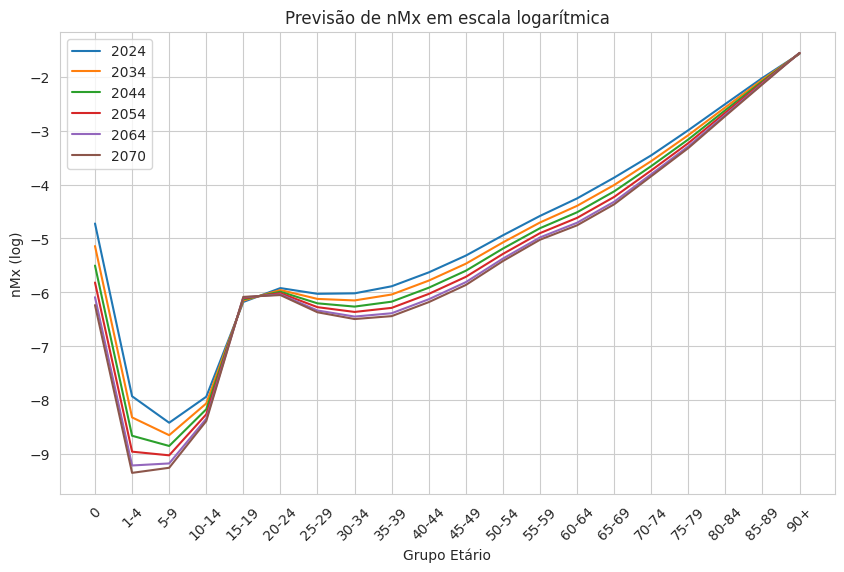

In [19]:
# Plotar Previsão de 2024, 2034, 2044, 2054, 2064, 2070
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_male[df_male['Ano'] == 2024], x='Grupo Etário', y=np.log(df_male[df_male['Ano'] == 2024]['Previsão']), label='2024')
sns.lineplot(data=df_male[df_male['Ano'] == 2034], x='Grupo Etário', y=np.log(df_male[df_male['Ano'] == 2034]['Previsão']), label='2034')
sns.lineplot(data=df_male[df_male['Ano'] == 2044], x='Grupo Etário', y=np.log(df_male[df_male['Ano'] == 2044]['Previsão']), label='2044')
sns.lineplot(data=df_male[df_male['Ano'] == 2054], x='Grupo Etário', y=np.log(df_male[df_male['Ano'] == 2054]['Previsão']), label='2054')
sns.lineplot(data=df_male[df_male['Ano'] == 2064], x='Grupo Etário', y=np.log(df_male[df_male['Ano'] == 2064]['Previsão']), label='2064')
sns.lineplot(data=df_male[df_male['Ano'] == 2070], x='Grupo Etário', y=np.log(df_male[df_male['Ano'] == 2070]['Previsão']), label='2070')
plt.xlabel('Grupo Etário')
plt.ylabel('nMx (log)')
plt.title('Previsão de nMx em escala logarítmica')
plt.legend()
plt.xticks(rotation=45) # Rotate y-axis labels by 45 degrees
plt.show()

In [21]:
# Carregar métricas de homens
df_male_metricas = pd.read_csv(os.path.join(pasta_download, "metricas_Brasil_Masculino.csv"))
df_male_metricas

,Local,Sexo,Grupo Etário,RMSE,sMAPE,MAE
0,Brasil,Masculino,0,0.001428,9.772729,0.001242
1,Brasil,Masculino,1-4,0.000071,12.211615,0.000063
2,Brasil,Masculino,5-9,0.000012,4.576841,0.000012
3,Brasil,Masculino,10-14,0.000031,7.506301,0.000028
4,Brasil,Masculino,15-19,0.000198,8.398722,0.000164
5,Brasil,Masculino,20-24,0.000141,4.310492,0.000118
6,Brasil,Masculino,25-29,0.000099,3.157761,0.000080
7,Brasil,Masculino,30-34,0.000096,2.893065,0.000075
8,Brasil,Masculino,35-39,0.000127,3.796399,0.000114
9,Brasil,Masculino,40-44,0.000216,5.252747,0.000204


In [22]:
# Carregar dados de mulheres
df_female = pd.read_csv(os.path.join(pasta_download, "proj_Brasil_Feminino.csv"))
df_female

,Local,Sexo,Ano,Grupo Etário,Previsão,Expectativa_Vida,Limite Inferior,Limite Superior
0,Brasil,Feminino,2020,0,0.009465,79.996008,0.007758,0.011546
1,Brasil,Feminino,2020,1-4,0.000388,NaN,0.000317,0.000474
2,Brasil,Feminino,2020,5-9,0.000199,NaN,0.000181,0.000220
3,Brasil,Feminino,2020,10-14,0.000235,NaN,0.000219,0.000253
4,Brasil,Feminino,2020,15-19,0.000453,NaN,0.000432,0.000476
...,...,...,...,...,...,...,...,...
1015,Brasil,Feminino,2070,70-74,0.013455,NaN,0.004299,0.042112
1016,Brasil,Feminino,2070,75-79,0.024523,NaN,0.008744,0.068776
1017,Brasil,Feminino,2070,80-84,0.046911,NaN,0.021020,0.104692
1018,Brasil,Feminino,2070,85-89,0.088310,NaN,0.048790,0.159841


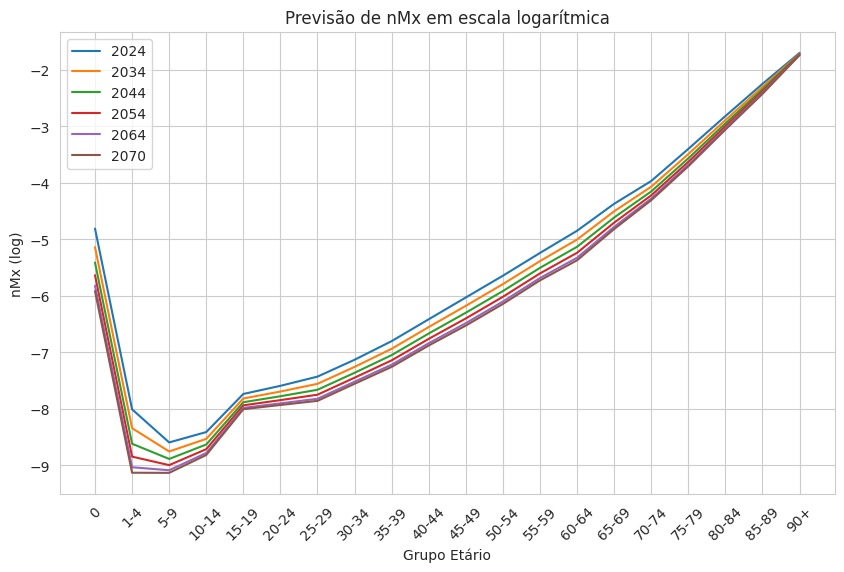

In [23]:
# Plotar Previsão de 2024, 2034, 2044, 2054, 2064, 2070
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_female[df_female['Ano'] == 2024], x='Grupo Etário', y=np.log(df_female[df_female['Ano'] == 2024]['Previsão']), label='2024')
sns.lineplot(data=df_female[df_female['Ano'] == 2034], x='Grupo Etário', y=np.log(df_female[df_female['Ano'] == 2034]['Previsão']), label='2034')
sns.lineplot(data=df_female[df_female['Ano'] == 2044], x='Grupo Etário', y=np.log(df_female[df_female['Ano'] == 2044]['Previsão']), label='2044')
sns.lineplot(data=df_female[df_female['Ano'] == 2054], x='Grupo Etário', y=np.log(df_female[df_female['Ano'] == 2054]['Previsão']), label='2054')
sns.lineplot(data=df_female[df_female['Ano'] == 2064], x='Grupo Etário', y=np.log(df_female[df_female['Ano'] == 2064]['Previsão']), label='2064')
sns.lineplot(data=df_female[df_female['Ano'] == 2070], x='Grupo Etário', y=np.log(df_female[df_female['Ano'] == 2070]['Previsão']), label='2070')
plt.xlabel('Grupo Etário')
plt.ylabel('nMx (log)')
plt.title('Previsão de nMx em escala logarítmica')
plt.legend()
plt.xticks(rotation=45) # Rotate y-axis labels by 45 degrees
plt.show()

In [24]:
# Carregar métricas de mulheres
df_female_metricas = pd.read_csv(os.path.join(pasta_download, "metricas_Brasil_Feminino.csv"))
df_female_metricas

,Local,Sexo,Grupo Etário,RMSE,sMAPE,MAE
0,Brasil,Feminino,0,0.000974,7.317123,0.000797
1,Brasil,Feminino,1-4,0.000044,9.055295,0.000041
2,Brasil,Feminino,5-9,0.000011,5.009564,0.000010
3,Brasil,Feminino,10-14,0.000003,1.220405,0.000003
4,Brasil,Feminino,15-19,0.000013,2.516945,0.000011
5,Brasil,Feminino,20-24,0.000015,2.329922,0.000013
6,Brasil,Feminino,25-29,0.000006,0.760656,0.000005
7,Brasil,Feminino,30-34,0.000006,0.563431,0.000005
8,Brasil,Feminino,35-39,0.000027,1.977134,0.000025
9,Brasil,Feminino,40-44,0.000013,0.623344,0.000011


In [25]:
# Carregar dados de ambos
df_both = pd.read_csv(os.path.join(pasta_download, "proj_Brasil_Ambos.csv"))
df_both

,Local,Sexo,Ano,Grupo Etário,Previsão,Expectativa_Vida,Limite Inferior,Limite Superior
0,Brasil,Ambos,2020,0,0.010012,76.439996,0.007786,0.012875
1,Brasil,Ambos,2020,1-4,0.000405,NaN,0.000318,0.000517
2,Brasil,Ambos,2020,5-9,0.000222,NaN,0.000194,0.000253
3,Brasil,Ambos,2020,10-14,0.000307,NaN,0.000283,0.000333
4,Brasil,Ambos,2020,15-19,0.001251,NaN,0.001254,0.001247
...,...,...,...,...,...,...,...,...
1015,Brasil,Ambos,2070,70-74,0.018671,NaN,0.005994,0.058165
1016,Brasil,Ambos,2070,75-79,0.031578,NaN,0.011366,0.087736
1017,Brasil,Ambos,2070,80-84,0.056718,NaN,0.026421,0.121756
1018,Brasil,Ambos,2070,85-89,0.101645,NaN,0.060565,0.170589


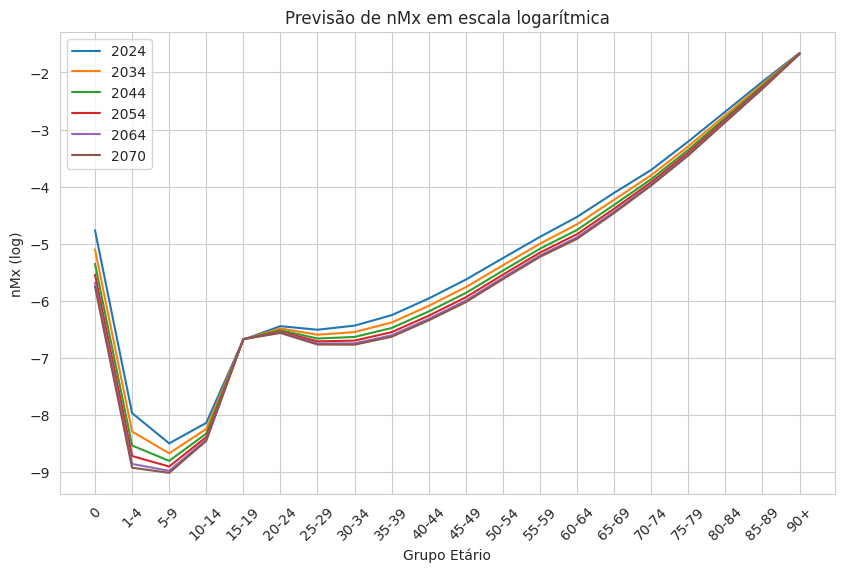

In [26]:
# Plotar Previsão de 2024, 2034, 2044, 2054, 2064, 2070
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_both[df_both['Ano'] == 2024], x='Grupo Etário', y=np.log(df_both[df_both['Ano'] == 2024]['Previsão']), label='2024')
sns.lineplot(data=df_both[df_both['Ano'] == 2034], x='Grupo Etário', y=np.log(df_both[df_both['Ano'] == 2034]['Previsão']), label='2034')
sns.lineplot(data=df_both[df_both['Ano'] == 2044], x='Grupo Etário', y=np.log(df_both[df_both['Ano'] == 2044]['Previsão']), label='2044')
sns.lineplot(data=df_both[df_both['Ano'] == 2054], x='Grupo Etário', y=np.log(df_both[df_both['Ano'] == 2054]['Previsão']), label='2054')
sns.lineplot(data=df_both[df_both['Ano'] == 2064], x='Grupo Etário', y=np.log(df_both[df_both['Ano'] == 2064]['Previsão']), label='2064')
sns.lineplot(data=df_both[df_both['Ano'] == 2070], x='Grupo Etário', y=np.log(df_both[df_both['Ano'] == 2070]['Previsão']), label='2070')
plt.xlabel('Grupo Etário')
plt.ylabel('nMx (log)')
plt.title('Previsão de nMx em escala logarítmica')
plt.legend()
plt.xticks(rotation=45) # Rotate y-axis labels by 45 degrees
plt.show()

In [27]:
# Carregar métricas de ambos
df_both_metricas = pd.read_csv(os.path.join(pasta_download, "metricas_Brasil_Ambos.csv"))
df_both_metricas

,Local,Sexo,Grupo Etário,RMSE,sMAPE,MAE
0,Brasil,Ambos,0,0.001268,9.273494,0.001094
1,Brasil,Ambos,1-4,0.000060,11.386455,0.000055
2,Brasil,Ambos,5-9,0.000012,4.735615,0.000011
3,Brasil,Ambos,10-14,0.000017,5.007913,0.000015
4,Brasil,Ambos,15-19,0.000101,6.932541,0.000084
5,Brasil,Ambos,20-24,0.000067,3.737451,0.000062
6,Brasil,Ambos,25-29,0.000046,2.519890,0.000040
7,Brasil,Ambos,30-34,0.000042,1.949673,0.000033
8,Brasil,Ambos,35-39,0.000049,1.869521,0.000039
9,Brasil,Ambos,40-44,0.000090,2.977519,0.000084
